# Applications to Time Series Analysis

In this notebook, we demonstrate how to use the Decorated Merge Trees (DMT) framework to understand qualitative topological features of a time series via Takens embeddings.

In this notebook, we use decorated merge trees to compare toy point cloud data. The experiments here correspond to Figure 10 from our paper:

[1] *Decorated Merge Trees for Persistenct Topology* by Justin Curry, Haibin Hang, Washington Mio, Tom Needham and Osman Okutan. Arxiv: [2103.15804](https://arxiv.org/abs/2103.15804)

We will refer back to specific sections of this paper throughout the notebook. For introductions to basic code functionality, please see earlier Jupyter notebooks in the repository.

In [1]:
# Import the usual modules
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
import persim
import networkx as nx
from sklearn import manifold

from DMT_tools import *
from example_generating_functions import *

import ot

import time

import warnings
warnings.filterwarnings("ignore")

# Import the gtda modules
from gtda.time_series import Resampler, SingleTakensEmbedding, SlidingWindow, PermutationEntropy
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Scaler, Filtering, PersistenceEntropy, BettiCurve, PairwiseDistance
from gtda.graphs import KNeighborsGraph, GraphGeodesicDistance
from gtda.pipeline import Pipeline
from gtda.plotting import plot_point_cloud

## Sliding Window Embeddings

To do TDA on time series, we transform a given time series into a higher-dimensional curve via a *sliding window embedding* or *Takens embedding*. See [this paper](https://link.springer.com/article/10.1007/s10208-014-9206-z) for a precise exposition of the underlying theory. For the readers' convenience, we give a brief description of the process here.

Give a time series (i.e., a function) $f:\mathbb{R} \to \mathbb{R}$, we construct the sliding window embedding associated to parameters $d \in \mathbb{Z}_{>1}$ and $\tau \in \mathbb{R}_{>0}$ as

\begin{align*}
\mathrm{SW}_{d,\tau} f: \mathbb{R} &\to \mathbb{R}^{d+1} \\
t &\mapsto (f(t),f(t+\tau),f(t + 2\tau), \ldots, f(t+d\tau)).
\end{align*}

Of course, in practice the function $f$ will be defined on a finite interval and we will only have access to finitely many samples of its values. The definition of $\mathrm{SW}_{d,\tau}f$ is easily adjusted accordingly. In this discrete setting, the resulting embedding will be a point cloud in $\mathbb{R}^{d+1}$, and persistent homology of the associated Vietoris-Rips complex gives topological features for the original time series. 

Generally, practicitioners tend to study the 1-dimensional persistent homology of the embedded point cloud, as this has theoretical ties to periodicity in the original time series. On the other hand, real world time series data frequently contains sharp jumps (change points). These jumps should correspond to persistent **degree-0** features in the embedded point cloud. We use the DMT framework to simultaneuously encode both these change point features and the periodicity coming from degree-1 homology.

## Synthetic Data

We will illustrate the process with synthetic data. We construct data to have periodic behavior, together with a sharp jump.

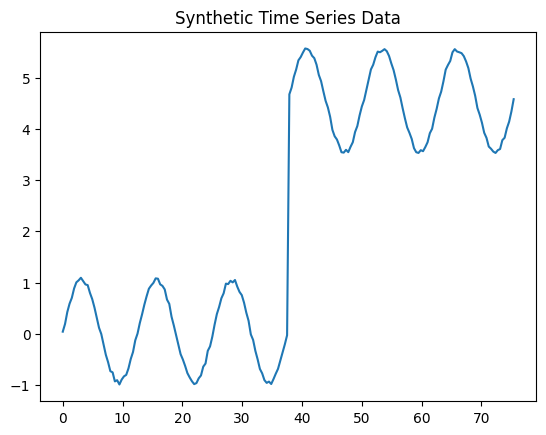

In [2]:
# Sine Curve Parameters
domain_start = 0
domain_end = 24*np.pi
n_samples = 200
freq = 1/2
noise_level = 0.1

# Construct the periodic signal
xs = np.linspace(domain_start,domain_end,n_samples)
signal0 = np.sin(xs*freq) + noise_level*np.random.random(n_samples)                

# Construct the full signal with a jump
signal = np.zeros(len(xs))
signal[:100] = signal0[:100]
signal[100:200] = signal0[100:200] + 4.5

# Plot the result
plt.plot(xs,signal)
plt.title('Synthetic Time Series Data')
plt.show()

To get a Takens embedding (aka sliding window embedding), we'll use the excellent TDA package `giotto`, from which we have already imported several useful functions.

The `giotto` Takens embedding function can search over parameters $d,\tau$, but requires an initial guess, which we input below.

In [3]:
dimension = 10
time_delay = 1

embedder = SingleTakensEmbedding(parameters_type='search',dimension=dimension,time_delay=time_delay)
embedded_signal = embedder.fit_transform(signal)

print('Shape of embedded point cloud:', embedded_signal.shape)

Shape of embedded point cloud: (194, 7)


To get an idea of the what the embedded point cloud looks like, we can project to a PCA plane.

In [4]:
from sklearn.decomposition import PCA

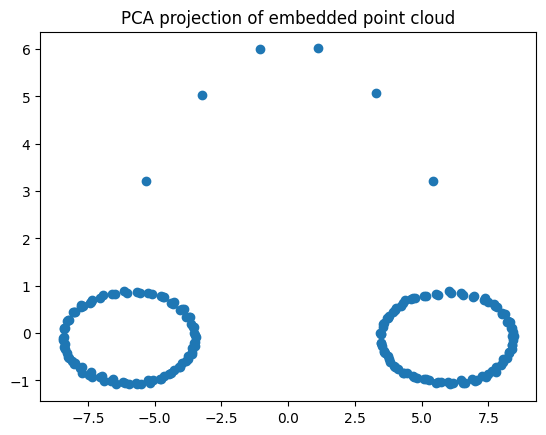

In [5]:
pca = PCA(n_components = 2)
pca_coords = pca.fit_transform(embedded_signal)

plt.scatter(pca_coords[:,0],pca_coords[:,1])
plt.title('PCA projection of embedded point cloud')
plt.show()

We see that the embedded signal seems to have two persistent connected components, each containing a single degree-1 (loop) feature. this reflects the jump in the original time series and the fact that the time series is periodic both before and after the jump.

Although there are apparently two distinct primary components, there is some amount of 'chaining' between them. To reduct this effect and accentuate the degree-0 features, we can mildly subsample by density.

Note that in a real data analysis pipeline, there are various parameter-selection steps ($d$, $\tau$, density-based subsampling) that would have to be tuned by cross-validation. We are 'hand selecting' parameters in this simple demonstration, however.

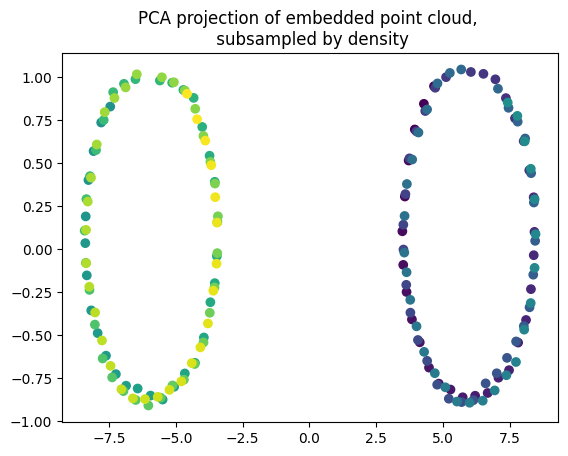

In [6]:
from sklearn.metrics import euclidean_distances

# Get a density score for each point
DistMat = euclidean_distances(embedded_signal)
mean_dist = np.mean(DistMat)
densities = [sum(DistMat[j,:] < mean_dist/5) for j in range(embedded_signal.shape[0])]

# Subsample by density
total_points = 180
cutoff = np.sort(densities)[::-1][total_points]
# idx = np.argsort(densities)[-total_points:]
embedded_signal_subsampled = embedded_signal[densities >= cutoff,:]

pca_coords = pca.fit_transform(embedded_signal_subsampled)

plt.scatter(pca_coords[:,0],pca_coords[:,1],c = list(range(len(pca_coords))))
plt.title('PCA projection of embedded point cloud, \n subsampled by density')
plt.show()

Now we can create a decorated merge tree for the subsampled embedded point cloud.

In [7]:
MT = MergeTree(pointCloud = embedded_signal_subsampled)
MT.fit_barcode(degree=1)

After choosing some threshold parameters to get a clean visualization, we can summarize the topology of the embedded point cloud via a DMT.

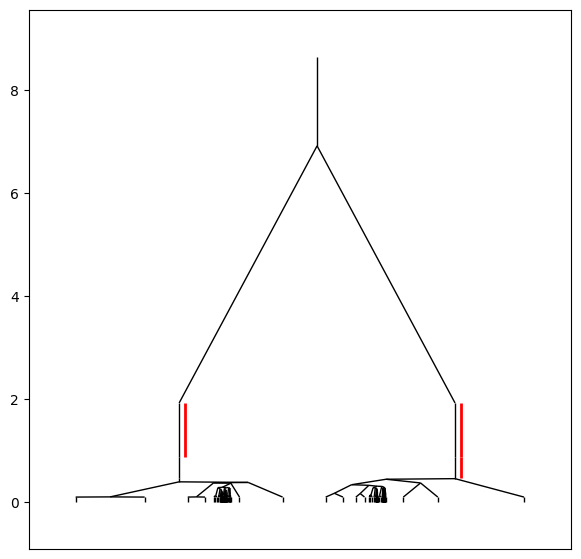

In [8]:
tree_thresh = 0.1
barcode_thresh = 0.1

MT.draw_decorated(tree_thresh,barcode_thresh)

This shows that there are two prominent connected components, each of which contains its own degree-1 cycle!

We can see the sources of these degree-1 bars in our original time series, but perhaps this would not always be so obvious. We can use the constructed DMT to locate the sources of the bars in the original time series.

The process is conceptually simple: for each bar of interest in the DMT, we mark each node descending from the birth point of the bar with an appropriate label. The labels on the nodes give us labels on the points of the original time series, so we can visualize points on the time series which belong to the connected component where a bar was born.

This takes a little bit of work to code. First, we will determine indices of points from the subsampled embedded point cloud which belong to each bar's cycle (that is, record the leaves which lie below each of the bars in the decorated merge tree).

In [9]:
num_bars = 2

node_labels = {}

barcode = MT.barcode
barcode_lengths = [bar[1]-bar[0] for bar in barcode]
barcode_idx_sorted_by_length = np.argsort(barcode_lengths)[::-1]

leaf_barcode = MT.leaf_barcode

for i in range(num_bars):
    
    labels = []
    
    idx = barcode_idx_sorted_by_length[i]
    bar = barcode[idx]
    
    for leaf, bc in leaf_barcode.items():
        if list(bar) in bc:
            labels.append(leaf)
            
    node_labels[i] = labels

Now we can color the plot of the time series signal according to which cycle each point belongs to.

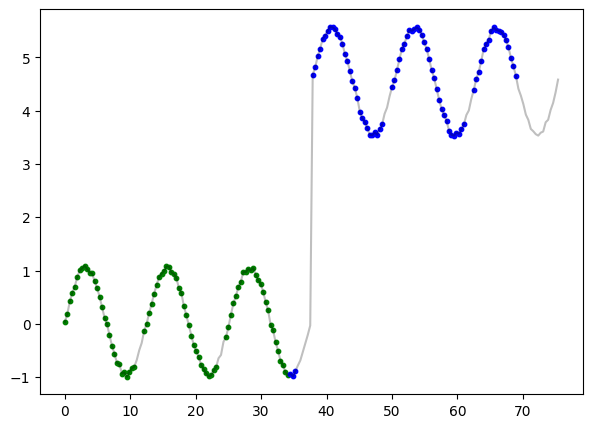

In [10]:
plt.figure(figsize = (7,5))
plt.plot(xs,signal, c = 'black', alpha = 0.25)

idx = [i for i in node_labels[0] if densities[i] > cutoff]
x_vals = xs[idx]
y_vals = signal[idx]

plt.scatter(xs[sorted(idx)],signal[sorted(idx)], c = 'g', s = 10)

idx = [i for i in node_labels[1] if densities[i] > cutoff]
x_vals = xs[idx]
y_vals = signal[idx]

plt.scatter(xs[sorted(idx)],signal[sorted(idx)], c = 'b', s = 10)
plt.show()